In [117]:
import re
import random
import pandas as pd
import hashlib

In [118]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [119]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Jane Eyre, Bronte",16.135171,2.016896,5.336889,8
Email Auth and Security,319.833604,39.979201,71.736930,8
Azure Functions + Visual Studio,458.054730,57.256841,90.852693,8
Debugging in VS Code,563.446036,51.222367,98.331977,11
Logging in Python,688.571655,49.183690,123.087828,14
Azure AD Authentication,714.535710,54.964285,136.320599,13
Azure Private DNS,737.667154,38.824587,82.593414,19
RAG Project,858.400916,53.650057,113.362251,16
C# Basics,871.700975,28.119386,48.931264,31
VMWare,903.580434,21.013498,33.988108,43


# Histogram

sum of ages: ~29868.16


<Axes: >

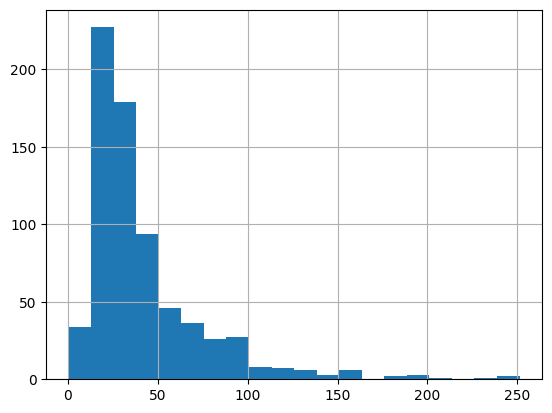

In [120]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [121]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [122]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [123]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [124]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [125]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [126]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [127]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [128]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 708
Total card age: 29868.16


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
36,Azure Developer Associate,Which Azure storage service supports a user de...,fd19a76de5cbe2ba07dc309378571330,-251.274347,47.365434,251.274347,-3694.50382,0.737589,0,0
37,Azure Developer Associate,What is a namespace in Azure Container Registr...,1b0ac1c1e13236781412e83d16112ac2,-189.685738,47.365434,251.274347,-3694.50382,0.737589,3,0
38,Azure Developer Associate,Front: What happens to Strong consistency read...,f28a0d3335e372744fa5eed634480678,-133.469673,47.365434,251.274347,-3694.50382,0.737589,6,0
39,Azure Developer Associate,What allows Azure App Service to integrate wit...,32290ecad251ac5c55d4207a493f2f7e,-88.938646,47.365434,251.274347,-3694.50382,0.737589,9,0
40,Azure Developer Associate,Which caching pattern loads data on demand int...,835f5f7d231724bc9594429a4497baf5,-71.922702,47.365434,251.274347,-3694.50382,0.737589,12,0
41,Azure Developer Associate,If you omit --restart-policy when creating an ...,38a8ebb2ee48f47efb9b454448546674,-68.943828,47.365434,251.274347,-3694.50382,0.737589,15,0
42,Azure Developer Associate,How do you correlate errors from Application I...,d2b1cb71a345cc2e58099a4572434c25,-64.647762,47.365434,251.274347,-3694.50382,0.737589,18,0
43,Azure Developer Associate,Which App Service log type contains the HTML f...,f6d9770fba82f6e3cf934e8c588e405c,-55.839922,47.365434,251.274347,-3694.50382,0.737589,21,0
44,Azure Developer Associate,How can each developer use one key to access m...,24285832dc2df8b6fb01f1b5df9f3541,-53.283475,47.365434,251.274347,-3694.50382,0.737589,24,0
45,Azure Developer Associate,How do you define triggers and bindings in a C...,2745f95072e8ccd497dad25f59f39a15,-47.129389,47.365434,251.274347,-3694.50382,0.737589,27,0


## Age Mean

In [129]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [130]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [131]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [132]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [133]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
36,Azure Developer Associate,Which Azure storage service supports a user de...,fd19a76de5cbe2ba07dc309378571330,-251.274347,47.365434,251.274347,-3694.503820,0.737589,0,0
280,Azure Developer Associate,What are the two primary data types collected ...,f0995a4e3eae52ece78cb2f025efcf7f,-250.635407,47.365434,251.274347,-3694.503820,0.737589,1,1
156,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-229.155413,53.916653,229.155413,-1132.249706,0.693521,0,0
62,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-203.858269,50.495620,203.858269,-3029.737209,0.047254,0,0
515,Azure Developer Associate,Which role grants least privilege to allow a u...,72ce544617e81069d717793d0c83d443,-193.626776,47.365434,251.274347,-3694.503820,0.737589,2,2
397,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-190.268457,53.916653,229.155413,-1132.249706,0.693521,1,1
37,Azure Developer Associate,What is a namespace in Azure Container Registr...,1b0ac1c1e13236781412e83d16112ac2,-189.685738,47.365434,251.274347,-3694.503820,0.737589,3,0
306,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,-183.818141,50.495620,203.858269,-3029.737209,0.047254,1,1
125,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-180.483845,53.488766,180.483845,-1711.640496,0.266100,0,0
96,Asynchronous Python,Lock (Mutex)\nA lock is a synchronization prim...,2218c022e468947a8bbd7ec0626cfe1e,-162.794549,44.145250,162.794549,-2030.681498,0.780647,0,0


In [134]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Which Azure storage service supports a user de...
hash                   fd19a76de5cbe2ba07dc3093785713301b0ac1c1e13236...
age                                                         -1025.135482
subject_mean_age                                              473.654336
subject_highest_age                                          2512.743466
subject_age_sum                                            -36945.038196
head_random_roll                                                7.375889
count                                                                135
n_fold                                                                 0
dtype: object

In [135]:
existing_cards['age'].mean()

-42.18666035968898